Volatility Surface Dataset
===
Forecasting Realized Vol with RF
---



In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import plotly.graph_objects as go
from scipy.stats import norm
from datetime import datetime
import ipywidgets
from sklearn.preprocessing import MinMaxScaler, PowerTransformer,QuantileTransformer
from fbprophet import Prophet as prh


In [2]:
#Import the datasets into dataframes
surfSPX = pd.read_csv('/home/student/surface/Realized Variance/DatasetSPX/RawData/VolSurf.csv')
priceSPX = pd.read_csv('/home/student/surface/Realized Variance/DatasetSPX/RawData/PriceSPX.csv')
zcr = pd.read_csv('/home/student/surface/Realized Variance/DatasetSPX/RawData/ZCR.csv')
realVol = pd.read_csv('/home/student/surface/Realized Variance/DatasetSPX/RawData/Realized_Vol.csv')
CBOE = pd.read_csv('/home/student/surface/Realized Variance/DatasetSPX/RawData/VIX.csv')

VolSurf
---

,date,20,25,30,35,40,45,50,55,60,65,70,75,80
0,19960104,0.104332,0.105451,0.106428,0.107824,0.108448,0.106729,0.103542,0.101044,0.100027,0.099807,0.099774,0.099634,0.099036
1,19960105,0.100957,0.101133,0.101635,0.102132,0.102412,0.102565,0.102917,0.103627,0.104548,0.105590,0.106746,0.107843,0.108564
2,19960108,0.100906,0.102567,0.104121,0.105071,0.105882,0.107593,0.110500,0.113951,0.117410,0.120844,0.124723,0.129833,0.137504
3,19960109,0.111328,0.109662,0.108846,0.109774,0.110648,0.107907,0.101246,0.095021,0.092604,0.092570,0.092260,0.090820,0.088285
4,19960110,0.122422,0.123622,0.123933,0.123604,0.123878,0.125716,0.128255,0.129853,0.130672,0.131897,0.133759,0.135703,0.137328


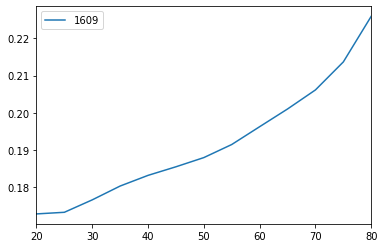

In [3]:
surfSPX = surfSPX[['date','days','delta','impl_volatility','impl_strike','cp_flag']]

#Transform panel date into timeseries date splitting different maturities into different dataframes. 
surfCall30 =  surfSPX[(surfSPX['days']==30) & (surfSPX['delta']>=0)].pivot('date','delta','impl_volatility').copy()
surfCall30 = pd.DataFrame(surfCall30.to_records())
surfCall60 =  surfSPX[(surfSPX['days']==60) & (surfSPX['delta']>=0)].pivot('date','delta','impl_volatility').copy()
surfCall60 = pd.DataFrame(surfCall60.to_records())
surfCall91 =  surfSPX[(surfSPX['days']==91) & (surfSPX['delta']>=0)].pivot('date','delta','impl_volatility').copy()
surfCall91 = pd.DataFrame(surfCall91.to_records())
surfCall122 = surfSPX[(surfSPX['days']==122) & (surfSPX['delta']>=0)].pivot('date','delta','impl_volatility').copy()
surfCall122 = pd.DataFrame(surfCall122.to_records())

#Plot! Data need to be transposed and the first point discarded because it corresponds to the date entry
surfCall30.loc[(surfCall30['date']==20020528)].T[1:].plot()
surfCall30.head()

Price SPX
---

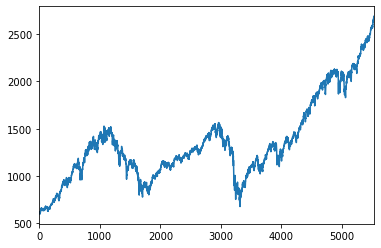

In [4]:
#Rename the column
priceSPX.rename(columns={'close':'SPXclose'},inplace=True)
priceSPX['ret'] = np.log(priceSPX['SPXclose']/priceSPX['SPXclose'].shift(1))

def stdnomean(array):
    'https://www.realvol.com/VolFormula.htm' #for reference
    std = np.power(array,2).sum()
    std = 252*std/(len(array))
    std = std**0.5
    return std

priceSPX['next30Vol'] = priceSPX['ret'].rolling(21).apply(stdnomean,raw=True)
#Drop useless columns
try:
    priceSPX.drop(columns=['secid','cfadj'], inplace=True)
except:
    None
#Plot    
priceSPX['SPXclose'].plot()

VIX
---

In [5]:
CBOE.rename(columns={'Date':'date'},inplace=True)

In [6]:
CBOE['date']=pd.to_datetime(CBOE.date,infer_datetime_format=True).dt.strftime('%Y%m%d').astype(int)
VIX = CBOE[['date','vixo','vixh','vixl','vix']]
VXO = CBOE[['date','vxoo','vxoh','vxol','vxo']]
VXN = CBOE[['date','vxno','vxnh','vxnl','vxn']].dropna(thresh=2)
#Note that VXN has O-H-L only after 2003. Between 2001-2003 has only close value. Before 2001 no data available.

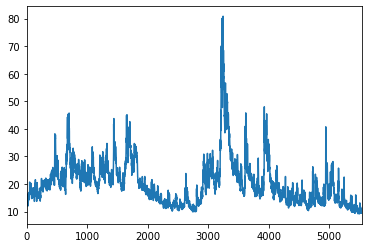

In [7]:
VIX['vix'].plot()

In [8]:
VIX

,date,vixo,vixh,vixl,vix
0,19960102,13.39,13.39,12.19,12.19
1,19960103,11.53,12.29,11.45,12.10
2,19960104,11.24,14.23,11.23,13.78
3,19960105,14.02,14.74,13.55,13.58
4,19960108,14.02,13.22,12.44,13.11
...,...,...,...,...,...
5535,20171222,9.37,10.18,9.35,9.90
5536,20171226,10.19,10.46,10.13,10.25
5537,20171227,10.04,10.79,9.71,10.47
5538,20171228,10.29,10.44,10.07,10.18


RealVol
----

In [9]:
try:
    realVol.drop(columns=['secid','index_flag'], inplace=True)
except:
    print('Already dropped')

In [10]:
realVol30  = realVol[realVol['days']==30 ].drop(columns='days').copy()
realVol30.rename(columns={'volatility':'realVol30'},inplace=True)
realVol60  = realVol[realVol['days']==60 ].drop(columns='days').copy()
realVol60.rename(columns={'volatility':'realVol60'},inplace=True)
realVol91  = realVol[realVol['days']==91 ].drop(columns='days').copy()
realVol91.rename(columns={'volatility':'realVol91'},inplace=True)
realVol122 = realVol[realVol['days']==122].drop(columns='days').copy()
realVol122.rename(columns={'volatility':'realVol122'},inplace=True)

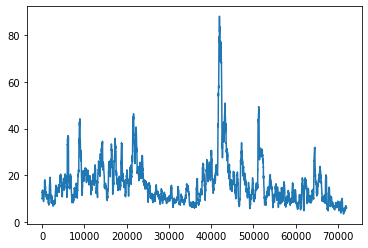

In [11]:
plt.plot(realVol30['realVol30']*100)


In [12]:
vol30 = pd.merge(VIX,realVol30, on='date')  #Real Vol need to be lagged in order to match the others. RealVol is not the future realized, but the past 30 days realized!
vol30 = pd.merge(vol30,surfCall30, on='date')
vol30 = pd.merge(vol30,priceSPX, on='date')

In [13]:
#Allign the 30-ahead realized volatility with the VIX 30-days ahead expected volatility
vol30['next30Vol'] = vol30['next30Vol'].shift(-21)
vol30.dropna(inplace=True)

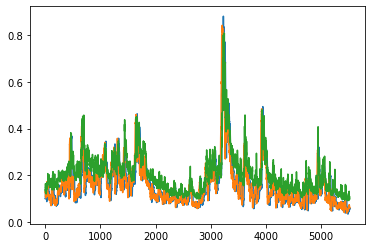

In [14]:
plt.plot(vol30['realVol30'])
plt.plot(vol30['next30Vol'])
plt.plot(vol30['vix']/100)

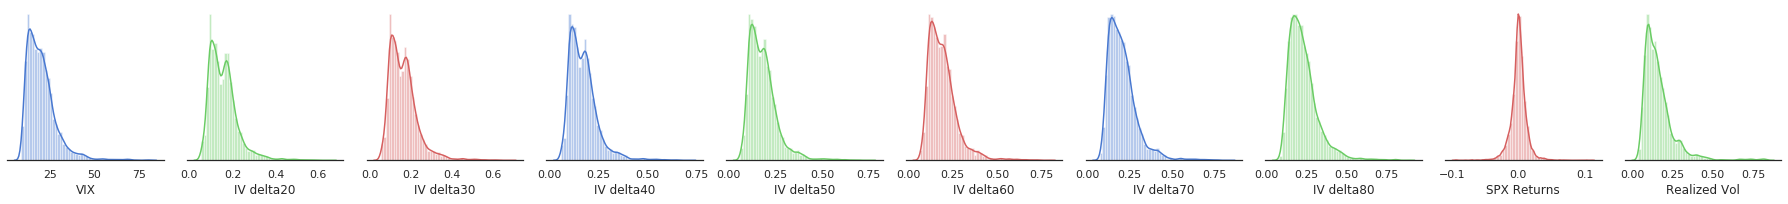

In [17]:
sns.set(style="white", palette="muted", color_codes=True)

# Set up the matplotlib figure
f, axes = plt.subplots(1,10, figsize=(25, 3))
sns.despine(left=True)


# Plot a simple histogram with binsize determined automatically
sns.distplot(vol30['vix'].values, color="b", ax=axes[0],axlabel='VIX')
sns.distplot(vol30['20'].values, color="g", ax=axes[1],axlabel='IV delta20')
sns.distplot(vol30['30'].values, color="r", ax=axes[2],axlabel='IV delta30')
sns.distplot(vol30['40'].values, color="b", ax=axes[3],axlabel='IV delta40')
sns.distplot(vol30['50'].values, color="g", ax=axes[4],axlabel='IV delta50')
sns.distplot(vol30['60'].values, color="r", ax=axes[5],axlabel='IV delta60')
sns.distplot(vol30['70'].values, color="b", ax=axes[6],axlabel='IV delta70')
sns.distplot(vol30['80'].values, color="g", ax=axes[7],axlabel='IV delta80')
sns.distplot(vol30['ret'].values, color="r", ax=axes[8],axlabel='SPX Returns')
sns.distplot(vol30['next30Vol'].values, color="g", ax=axes[9],axlabel='Realized Vol')

plt.setp(axes, yticks=[])
plt.tight_layout()

Scale Date 
---

### Improve Convergence and Feature Importance Robustness

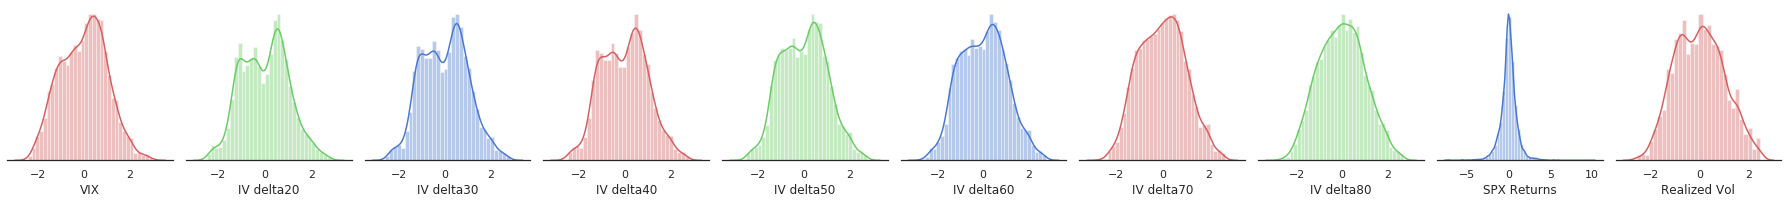

In [18]:
#Choose the one that is better (????)
scaler = MinMaxScaler()   #Keeps distribution shape bu normalize between 0-1
scaler = QuantileTransformer(n_quantiles=round(len(vol30)/100),output_distribution='uniform') #Keep ordering only, maps to a uniform
scaler = PowerTransformer() #Keeps ordering only, maps to a standard Gaussian N(0,1)

scaled_vol30 = vol30.copy()
scaled_vol30.iloc[:,1:] = scaler.fit_transform(vol30.iloc[:,1:])

sns.set(style="white", palette="muted", color_codes=True)

# Set up the matplotlib figure
f, axes = plt.subplots(1,10, figsize=(25, 3))
sns.despine(left=True)


# Plot a simple histogram with binsize determined automatically
sns.distplot(scaled_vol30['vix'].values, color="r", ax=axes[0],axlabel='VIX')
sns.distplot(scaled_vol30['20'].values, color="g", ax=axes[1],axlabel='IV delta20')
sns.distplot(scaled_vol30['30'].values, color="b", ax=axes[2],axlabel='IV delta30')
sns.distplot(scaled_vol30['40'].values, color="r", ax=axes[3],axlabel='IV delta40')
sns.distplot(scaled_vol30['50'].values, color="g", ax=axes[4],axlabel='IV delta50')
sns.distplot(scaled_vol30['60'].values, color="b", ax=axes[5],axlabel='IV delta60')
sns.distplot(scaled_vol30['70'].values, color="r", ax=axes[6],axlabel='IV delta70')
sns.distplot(scaled_vol30['80'].values, color="g", ax=axes[7],axlabel='IV delta80')
sns.distplot(scaled_vol30['ret'].values, color="b", ax=axes[8],axlabel='SPX Returns')
sns.distplot(scaled_vol30['next30Vol'].values, color="r", ax=axes[9],axlabel='Realized Vol')

plt.setp(axes, yticks=[])
plt.tight_layout()

In [19]:
scaled_vol30

,date,vixo,vixh,vixl,vix,realVol30,20,25,30,35,...,50,55,60,65,70,75,80,SPXclose,ret,next30Vol
0,19960104,-1.658704,-0.940869,-1.525565,-0.910466,-0.807745,-0.922442,-0.951737,-0.992211,-1.025331,...,-1.365693,-1.520398,-1.644661,-1.759239,-1.886037,-2.042622,-2.239823,-2.461388,-0.518680,-0.271417
1,19960105,-0.869883,-0.821497,-0.865225,-0.960067,-0.830406,-1.011663,-1.065149,-1.117504,-1.173356,...,-1.382300,-1.451024,-1.522607,-1.602723,-1.697063,-1.820397,-1.986234,-2.467070,-0.166020,-0.208482
2,19960108,-0.869883,-1.197506,-1.158545,-1.081026,-0.828099,-1.013028,-1.027082,-1.051970,-1.096164,...,-1.185636,-1.185832,-1.195356,-1.218057,-1.248309,-1.280041,-1.300551,-2.457032,0.205870,-0.167896
3,19960109,-1.119111,-0.659010,-0.995416,-0.584677,-0.599600,-0.744518,-0.844566,-0.930648,-0.976003,...,-1.427062,-1.687100,-1.853509,-1.963998,-2.099838,-2.294881,-2.544530,-2.509057,-1.245335,-0.325511
4,19960110,-0.332574,-0.383632,-0.397257,-0.346675,-0.305595,-0.480675,-0.512066,-0.569995,-0.645281,...,-0.763803,-0.812472,-0.886559,-0.962871,-1.041996,-1.148186,-1.304370,-2.573579,-1.529356,-0.568859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5511,20171122,-2.275181,-2.309888,-2.239769,-2.129376,-1.884239,-2.152717,-2.207446,-2.237879,-2.254435,...,-2.259381,-2.246771,-2.225630,-2.194503,-2.149405,-2.082201,-1.972071,2.193647,-0.094716,-1.621815
5512,20171124,-2.183800,-2.276930,-2.585579,-2.214733,-1.932757,-2.074797,-2.143552,-2.188496,-2.216926,...,-2.244903,-2.238240,-2.222013,-2.195054,-2.153834,-2.084053,-1.946907,2.199721,0.140335,-1.629740
5513,20171127,-2.083525,-2.156731,-2.045494,-2.133381,-2.093827,-1.988987,-2.029701,-2.055465,-2.069750,...,-2.056514,-2.031812,-1.994340,-1.940055,-1.858057,-1.720673,-1.480801,2.198584,-0.064087,-1.628515
5514,20171128,-2.224963,-2.137200,-2.151263,-2.070002,-1.835155,-1.856360,-1.910656,-1.958570,-1.999263,...,-2.086529,-2.105450,-2.118413,-2.121671,-2.109478,-2.071327,-1.982050,2.227540,0.795387,-1.892019


# Prophet

In [144]:
df = VIX[['date','vix']].copy()

In [145]:
df['date'] = pd.to_datetime(df['date'],format='%Y%m%d')
df.rename(columns={'date': 'ds','vix':'y'},inplace=True)

In [167]:
df['floor'] = 7
df['cap'] = 100

In [168]:
df

,ds,y,floor,cap
0,1996-01-02,12.19,7,100
1,1996-01-03,12.10,7,100
2,1996-01-04,13.78,7,100
3,1996-01-05,13.58,7,100
4,1996-01-08,13.11,7,100
...,...,...,...,...
5535,2017-12-22,9.90,7,100
5536,2017-12-26,10.25,7,100
5537,2017-12-27,10.47,7,100
5538,2017-12-28,10.18,7,100


In [173]:
m = Prophet()
m.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [174]:
future = m.make_future_dataframe(periods=365)
future['floor'] = 7
future['cap'] = 100
future.tail()

,ds,floor,cap
5900,2018-12-25,7,100
5901,2018-12-26,7,100
5902,2018-12-27,7,100
5903,2018-12-28,7,100
5904,2018-12-29,7,100


In [175]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
5900,2018-12-25,11.749660,4.710386,19.154175
5901,2018-12-26,11.644711,4.418129,19.405818
5902,2018-12-27,11.570245,4.027692,18.833593
5903,2018-12-28,11.407277,4.152478,19.392051
5904,2018-12-29,9.688320,1.972313,17.670666


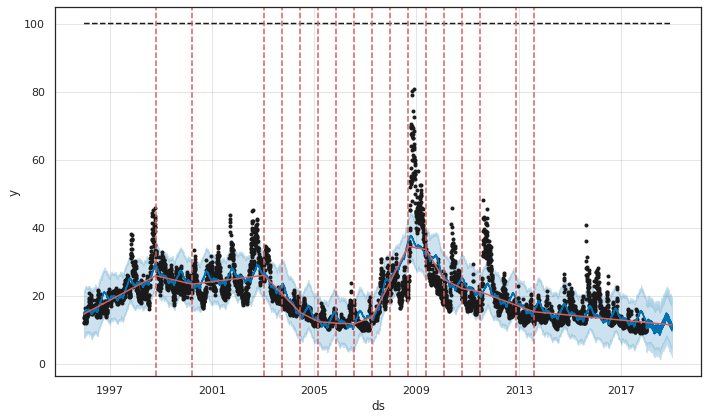

In [176]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


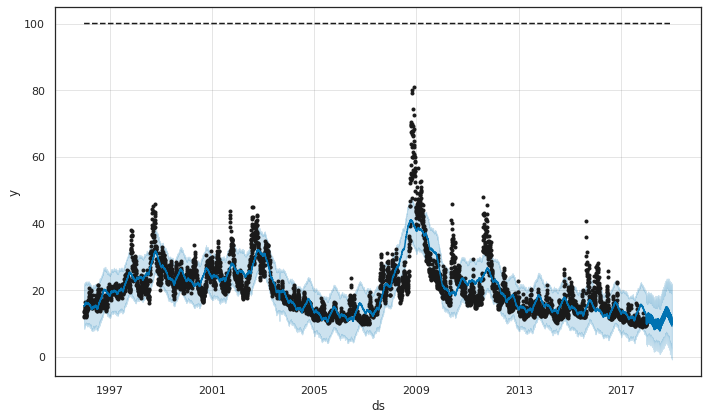

In [178]:
m = Prophet(changepoint_prior_scale=0.7)
forecast = m.fit(df).predict(future)
fig = m.plot(forecast)

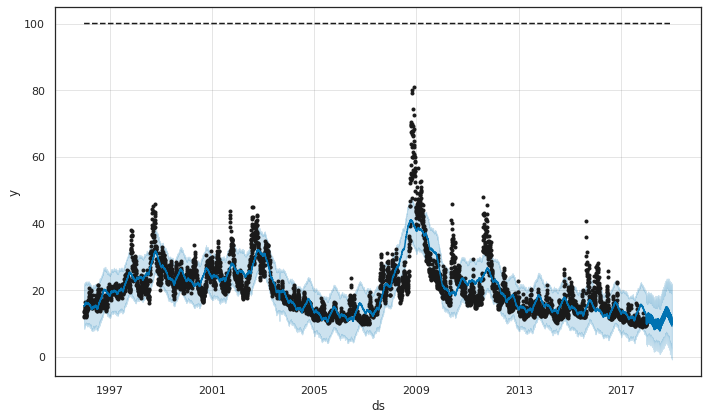

In [179]:
fig1 = m.plot(forecast)

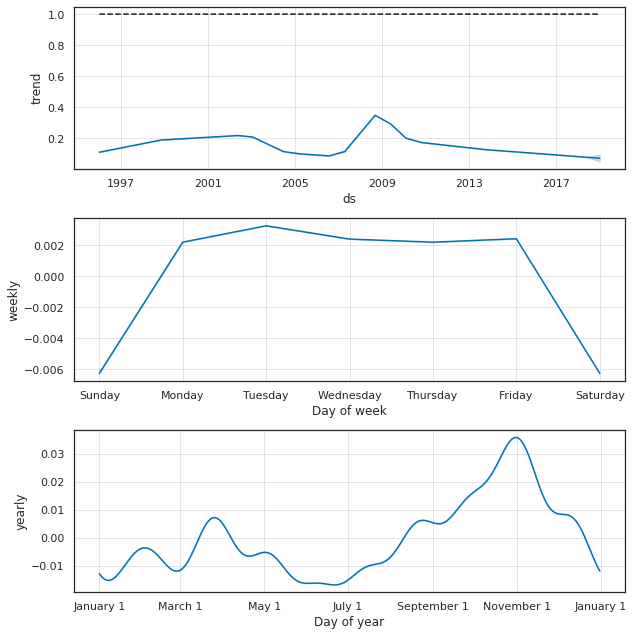

In [103]:
fig2 = m.plot_components(forecast)
